In [1]:
import h5py
import numpy as np
import sys
import tensorflow as tf
from tensorflow.keras import layers, optimizers, activations, initializers,regularizers, constraints
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv1D,Convolution2D, MaxPooling1D, AlphaDropout,Layer, LSTM, Layer
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers
#from tensorflow_addons.layers import MultiHeadAttention
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import sklearn, json
import scipy.io as io
from typing import Any, Dict
import logging, sys
from attention import Attention
logging.disable(sys.maxsize)
path = '/home/maria/'
sys.path.insert(0, path + "AMC/includes")
from clr_callback import *
import matplotlib.pyplot as plt


2022-10-19 16:14:58.327151: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [4]:
dataset_path = path + 'Dataset_trials/'

In [2]:
def load_data(dataset_path : str, subset : str,AF : bool):
    with h5py.File(dataset_path +'X_'+ subset +'.mat', 'r') as f:
        X = np.array(f['X_' + subset]).T
    Y = io.loadmat(dataset_path + 'Y_'+subset+'.mat')
    Y = Y['Y_' + subset]

    if AF:
        I_tr = X[:, :, 0]
        Q_tr = X[:, :, 1]
        X_tr = I_tr + 1j * Q_tr

        X[:, :, 1] = np.arctan2(Q_tr, I_tr) / np.pi
        X[:, :, 0] = np.abs(X_tr)

        del I_tr
        del Q_tr
        del X_tr
    np.random.seed(2022)
    X, Y = sklearn.utils.shuffle(X[:], Y[:], random_state=2022)
    return X, Y


In [5]:
X_train, Y_train = load_data(dataset_path, 'train', False)
X_val, Y_val = load_data(dataset_path, 'val', False)
X_test, Y_test = load_data(dataset_path, 'test', False)


In [51]:
class AttentionModel(Model):
    def __init__(self):
        super(Attention, self).__init__()
        self.lstm0 = LSTM(128, return_sequences=True, name='lstm0')
        self.lstm1 = LSTM(128, return_sequences=True, name='lstm0')
        self.attention_block =  tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim = 128)
        self.pooling = MaxPooling1D(4)
        self.flatten = Flatten()
        self.classification = Dense(8, activation='softmax', name='fc0')
        
    def call(self, x_input):
        x = self.lstm0(x_input)
        x = self.lstm1(x)
        x = self.attention_block(query=x,key=x,value=x)
        x = self.pooling(x)
        x = self.flatten(x)
        return self.classification(x)

In [52]:
model = Attention()

In [53]:
output_path = path + 'Results_lstm'
clr_triangular = CyclicLR(mode='triangular', base_lr=1e-7, max_lr=1e-3,
        step_size= 4 * (X_train.shape[0] // 256))
c = [clr_triangular, ModelCheckpoint(filepath= output_path +'/best_model.h5', monitor='val_loss', save_best_only=True)]
model.compile(optimizer=optimizers.Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])


In [54]:
Train = True
if Train:
    history = model.fit(X_train, Y_train, epochs = 1, batch_size = 256, callbacks = c, validation_data=(X_val, Y_val))
    with open(output_path +'/history_rnn.json', 'w') as f:
        json.dump(history.history, f)
    model_json = model.to_json()
    with open(output_path +'/model_rnn.json', "w") as json_file:
        json_file.write(model_json)
else:
    model.load_weights(output_path +'/best_model.h5')
    with open(output_path +'/history_rnn.json', 'r') as f:
        history = json.load(f)

2022-10-19 16:32:45.267227: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1002700800 exceeds 10% of free system memory.
2022-10-19 16:32:48.483032: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-10-19 16:32:49.129895: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


 10/479 [..............................] - ETA: 2:47 - loss: 2.0794 - accuracy: 0.1256

KeyboardInterrupt: 

In [5]:
classes = ['LFM', 'BFSK', 'BPSK', 'NM', 'LFM_ESC', 'SIN', 'BASK']

In [7]:
def getConfusionMatrixPlot(true_labels, predicted_labels,title):
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm = np.nan_to_num(cm_norm)
    cm = np.round(cm_norm,2)
    print(cm)

    # create figure
    width = 18
    height = width / 1.618
    fig = plt.figure(figsize=(width, height))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    res = ax.imshow(cm, cmap=plt.cm.binary,
                    interpolation='nearest', vmin=0, vmax=1)

    # add color bar
    plt.colorbar(res)

    # annotate confusion entries
    width = len(cm)
    height = len(cm[0])

    for x in range(width):
        for y in range(height):
            ax.annotate(str(cm[x][y]), xy=(y, x), horizontalalignment='center',
                        verticalalignment='center', color=getFontColor(cm[x][y]))

    # add genres as ticks
    alphabet = classes
    plt.xticks(range(width), alphabet[:width], rotation=30)
    plt.yticks(range(height), alphabet[:height])
    plt.title(title)
    return plt

In [23]:
dd

In [22]:
classes[1]

'BFSK'

In [27]:
signal_class[classes[2]]

array([0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.04, 0.07, 0.06, 0.07, 0.07,
       0.07, 0.09, 0.05, 0.08, 0.13, 0.09])

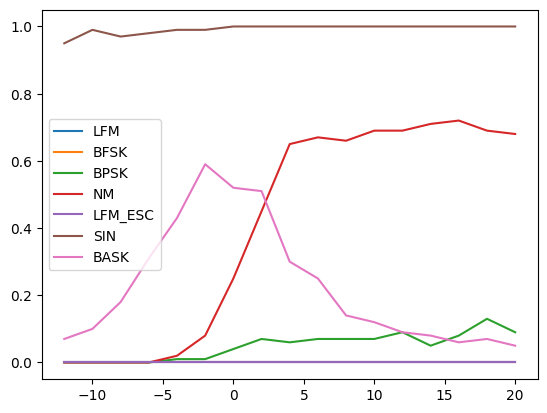

<Figure size 640x480 with 0 Axes>

In [31]:
plt.figure()
for i in range(len(classes)):
    plt.plot(snrs, signal_class[classes[i]])
plt.legend(classes)
plt.show()
plt.savefig(output_path+ '/graphs/signal_accuracy.pdf')

[0.12394578 0.12298436 0.12576473 0.12073372 0.17701156 0.17768778
 0.15187205]
[[  0   0   0   0   0 285  15]
 [  0   0   0   0   0 285  15]
 [  0   0   0   0   0 285  15]
 [  0   0   0   0   0 279  21]
 [  0   0   0   0   0 290  10]
 [  0   0   0   0   0 286  14]
 [  0   0   0   0   0 279  21]]
[[0.   0.   0.   0.   0.   0.95 0.05]
 [0.   0.   0.   0.   0.   0.95 0.05]
 [0.   0.   0.   0.   0.   0.95 0.05]
 [0.   0.   0.   0.   0.   0.93 0.07]
 [0.   0.   0.   0.   0.   0.97 0.03]
 [0.   0.   0.   0.   0.   0.95 0.05]
 [0.   0.   0.   0.   0.   0.93 0.07]]


NameError: name 'getFontColor' is not defined

<Figure size 1800x1112.48 with 0 Axes>

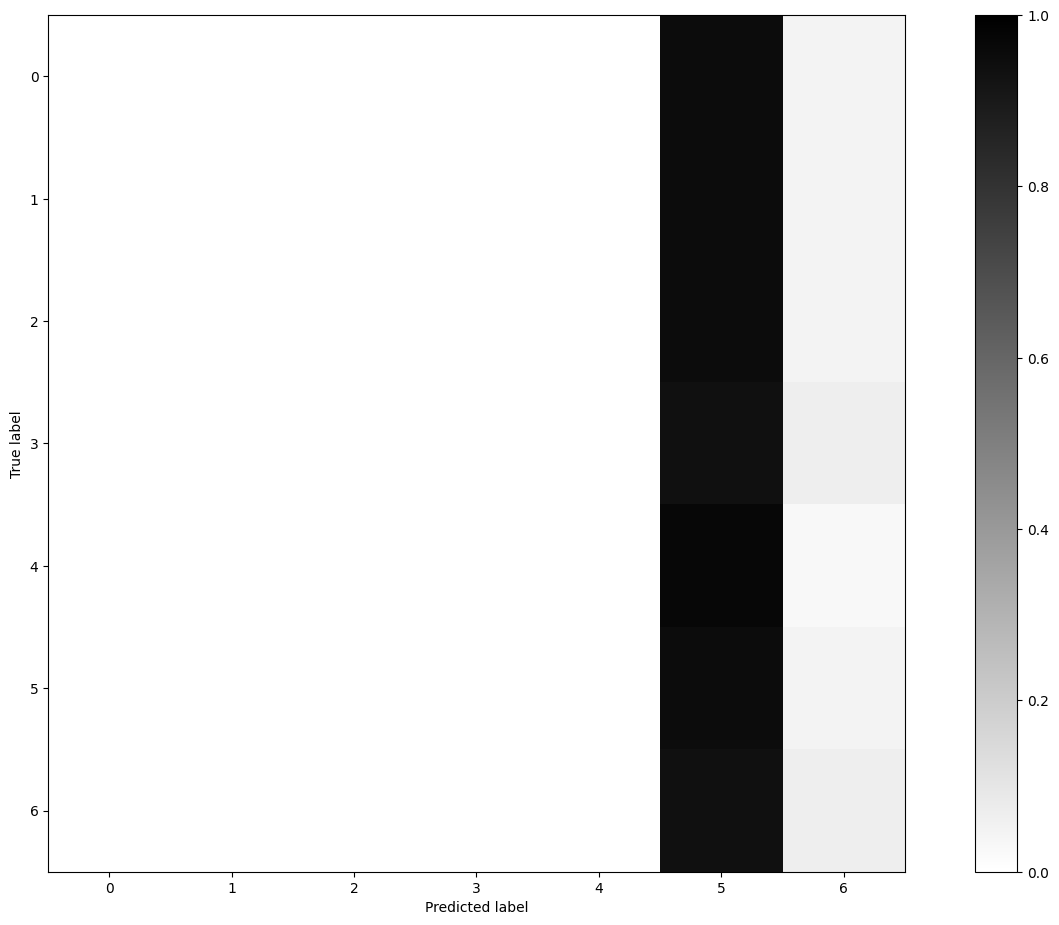

In [8]:
acc={}
snrs = [-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18,20]

for snr in snrs:
    test_SNRs = list(map(lambda x: lbl_test[x][1], range(0,X_test.shape[0])))
    test_X_i = X_test[[i for i,x in enumerate(test_SNRs) if x==snr]]
    test_Y_i = Y_test[[i for i,x in enumerate(test_SNRs) if x==snr]]
    test_Y_i_hat = np.array(model.predict(test_X_i))
    cm = confusion_matrix(np.argmax(test_Y_i, 1), np.argmax(test_Y_i_hat,1))
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm = np.nan_to_num(cm_norm)
    cm = np.round(cm_norm,2)
    
    for i in range(len(classes)):
        signal_class[classes[i]][j]= cm[i][i]
    width = 18
    height = width / 1.618
    plt.figure(figsize=(width, height))
    plt = getConfusionMatrixPlot(np.argmax(test_Y_i, 1), np.argmax(test_Y_i_hat,
        1),title="Attention Confusion Matrix (SNR=%d)"%(snr))
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.savefig(output_path + '/graphs/confmat_'+str(snr)+'.pdf')
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    cor = np.sum(np.diag(conf))
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)
    with open(output_path + '/acc.json', 'w') as f:
        json.dump(acc, f)

In [13]:
model_path = '/home/maria/Results_7signals/Results_lstm1'

In [14]:
from tensorflow.keras.models import load_model
loaded_model = load_model(model_path + '/best_model.h5')

In [9]:
snrs = [-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18,20]
classes = ['LFM', 'BFSK', 'BPSK', 'NM', 'LFM_ESC', 'SIN', 'BASK']
signal_class = {classes[0]: np.zeros(17), classes[1]: np.zeros(17),classes[2]:np.zeros(17), classes[3] : np.zeros(17), classes[4]: np.zeros(17), classes[5]:np.zeros(17), classes[6]:np.zeros(17)}

    

In [15]:
for j,snr in enumerate(snrs):
    test_SNRs = list(map(lambda x: lbl_test[x][1], range(0,X_test.shape[0])))
    test_X_i = X_test[[i for i,x in enumerate(test_SNRs) if x==snr]]
    test_Y_i = Y_test[[i for i,x in enumerate(test_SNRs) if x==snr]]
    test_Y_i_hat = np.array(loaded_model.predict(test_X_i))
    cm = confusion_matrix(np.argmax(test_Y_i, 1), np.argmax(test_Y_i_hat,1))
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm = np.nan_to_num(cm_norm)
    cm = np.round(cm_norm,2)
    
    for i in range(len(classes)):
        signal_class[classes[i]][j]= cm[i][i]

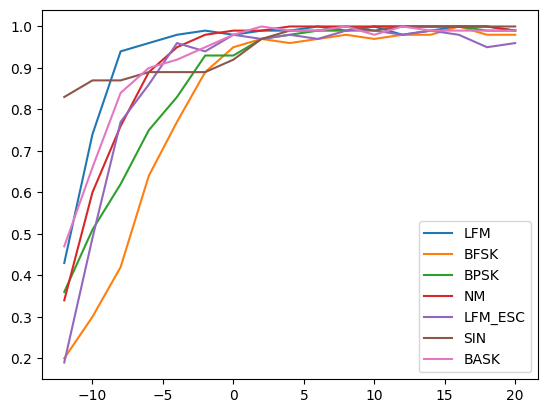

In [19]:
plt.figure()
for i in range(len(classes)):
    plt.plot(snrs, signal_class[classes[i]])
plt.legend(classes)
#plt.show()
plt.savefig(model_path + '/graphs/signal_accuracy.pdf')